In [105]:
import torch
import torch.nn as nn
import torchmetrics
import matplotlib.pyplot as plt
import torch.nn.functional as F

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [106]:


plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [107]:
def evaluation_func(model, dataloader, metrics):
    model.eval()
    metrics.reset()
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            if isinstance(y_pred, tuple):
                y_pred = y_pred.output
            pred = y_pred.contiguous()
            y_batch = y_batch.contiguous()
            metrics.update(pred, y_batch)
        return metrics.compute()

def training_func(model, optimizer, loss_fn, metric, train_loader, val_loader, n_epochs, patience = 2, factor = 0.5, epoch_callback = None):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', patience = patience, factor = factor
    )
    history = {'train_loss': [], 'train_metrics': [], 'val_metric': []}
    for epoch in range(n_epochs):
        model.train()
        metric.reset()
        train_loss = 0.0
        if epoch_callback is not None:
            epoch_callback(model,epoch)
        for index, (x_batch, y_batch) in enumerate(train_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            train_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            if isinstance(y_pred, tuple):
                y_pred = y_pred.output
            pred = y_pred.contiguous()
            y_batch = y_batch.contiguous()
            metric.update(pred, y_batch)
            train_metric = metric.compute().item()
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_metrics'].append(train_metric)
        validated_metric = evaluation_func(model, val_loader, metric).item()
        history['val_metric'].append(validated_metric)
        scheduler.step(validated_metric)
        print(f'Epoch {epoch + 1} / {n_epochs}: Train Loss: {history['train_loss'][-1]: .4f}, Train Metric = {history['train_metrics'][-1]:.4f}, Valid Metric = {history["val_metric"][-1]:.4f}, Scheduler Best[{scheduler.best:.4f}]')
    return history

##### Performing PCA with an Undercomplete Linear Autoencoder

In [108]:
torch.manual_seed(42)
encoder = nn.Linear(3, 2)
decoder = nn.Linear(2, 3)
autoencoder = nn.Sequential(encoder, decoder).to(device)

In [109]:
import numpy as np
from scipy.spatial.transform import Rotation

def generate_data(m, seed= 42):
    X = np.zeros((m, 3))
    rng = np.random.default_rng(seed)
    angles = (rng.random(m) ** 3 + 0.5) * 2 * np.pi
    X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5
    X += 0.28 * rng.standard_normal((m, 3))
    X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
    X += [0.2, 0, 0.2]
    return torch.from_numpy(X.astype(np.float32))

In [110]:
from torch.utils.data import DataLoader, TensorDataset

X_train = generate_data(60, seed=42)
X_val = generate_data(500, seed=1)
train_set = TensorDataset(X_train, X_train)
val_set = TensorDataset(X_val, X_val)
trainloader = DataLoader(train_set, batch_size= 32, shuffle=True)
validloader = DataLoader(val_set, batch_size= 32)

In [111]:
torch.manual_seed(42)
optimizer = torch.optim.NAdam(autoencoder.parameters(), lr = 0.2)
mse = nn.MSELoss()
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)
history = training_func(autoencoder, optimizer, mse, rmse, trainloader, validloader, 20)

Epoch 1 / 20: Train Loss:  0.1621, Train Metric = 0.4057, Valid Metric = 0.3095, Scheduler Best[0.3095]
Epoch 2 / 20: Train Loss:  0.0697, Train Metric = 0.2636, Valid Metric = 0.2964, Scheduler Best[0.3095]
Epoch 3 / 20: Train Loss:  0.0644, Train Metric = 0.2531, Valid Metric = 0.3238, Scheduler Best[0.3238]
Epoch 4 / 20: Train Loss:  0.0935, Train Metric = 0.3028, Valid Metric = 0.4551, Scheduler Best[0.4551]
Epoch 5 / 20: Train Loss:  0.1088, Train Metric = 0.3359, Valid Metric = 0.2465, Scheduler Best[0.4551]
Epoch 6 / 20: Train Loss:  0.0415, Train Metric = 0.2027, Valid Metric = 0.2346, Scheduler Best[0.4551]
Epoch 7 / 20: Train Loss:  0.0426, Train Metric = 0.2046, Valid Metric = 0.2768, Scheduler Best[0.4551]
Epoch 8 / 20: Train Loss:  0.0470, Train Metric = 0.2184, Valid Metric = 0.2119, Scheduler Best[0.4551]
Epoch 9 / 20: Train Loss:  0.0314, Train Metric = 0.1790, Valid Metric = 0.2131, Scheduler Best[0.4551]
Epoch 10 / 20: Train Loss:  0.0300, Train Metric = 0.1739, Valid

In [112]:
codings = encoder(X_train.to(device))

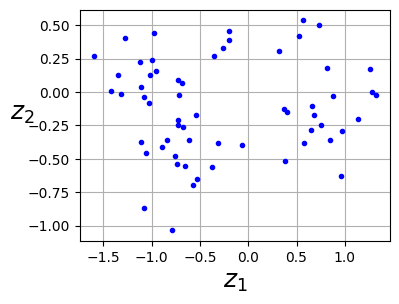

In [113]:
fig = plt.figure(figsize=(4,3))
codings_np = codings.cpu().detach().numpy()
plt.plot(codings_np[:,0], codings_np[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

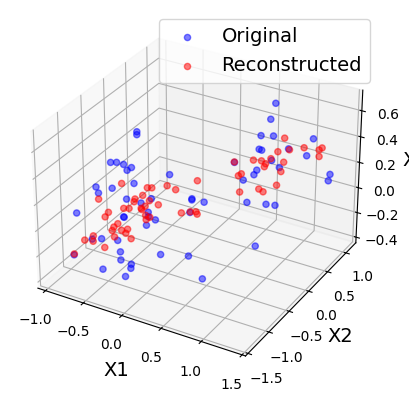

In [114]:
x_recon = decoder(codings)
#Plot 3D
autoencoder.eval()
with torch.no_grad():
    X_recon = autoencoder(X_train.to(device)).cpu().numpy()

X = X_train.cpu().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='blue', alpha=0.5, label="Original")
ax.scatter(X_recon[:, 0], X_recon[:, 1], X_recon[:, 2],
           c='red', alpha=0.5, label="Reconstructed")

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.legend()
plt.show()


##### Stacked Autoencoder

In [115]:
torch.manual_seed(42)

stacked_encoder = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1 * 28 * 28, 128),
    nn.ReLU(),
    nn.Linear(128, 32),
    nn.ReLU()
)

stacked_decoder = nn.Sequential(
    nn.Linear(32, 128),
    nn.ReLU(),
    nn.Linear(128, 1 * 28 * 28),
    nn.Sigmoid(),
    nn.Unflatten(dim = 1, unflattened_size=(1, 28, 28) )
)

stacked = nn.Sequential(
    stacked_encoder,
    stacked_decoder
).to(device)

In [116]:
import torchvision
import torchvision.transforms.v2 as transforms

toTensor = transforms.Compose([transforms.ToImage(),  transforms.ToDtype(torch.float32, scale=True)])
train_valid_data = torchvision.datasets.FashionMNIST(
    root ='datasets', train=True, download=True, transform=toTensor
)
test_data = torchvision.datasets.FashionMNIST(
    root ='datasets', train=False, download=True, transform=toTensor
)

In [117]:
torch.manual_seed(42)
train_data, valid_data = torch.utils.data.random_split(
    train_valid_data, [55000, 5000])

In [118]:
from torch.utils.data import Dataset

class AutoendcoderDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, _ = self.dataset[idx]
        return x, x
train_loader = DataLoader(AutoendcoderDataset(train_data), batch_size= 32, shuffle=True)
val_loader = DataLoader(AutoendcoderDataset(valid_data), batch_size= 32)
test_loader = DataLoader(AutoendcoderDataset(test_data), batch_size= 32)

In [119]:
rmse = torchmetrics.MeanSquaredError(squared= False).to(device)

In [120]:
optimizer = torch.optim.NAdam(stacked.parameters(), lr = 0.001)
loss_fn = nn.MSELoss()
history = training_func(stacked, optimizer, loss_fn, rmse, train_loader, val_loader, 20)

KeyboardInterrupt: 

In [38]:
def plot_image(image):
    plt.imshow(image.permute(1,2,0).cpu(), cmap='binary')
    plt.axis('off')

def plot_reconstruction(model, images, n_image):
    images = images[:n_image]
    with torch.no_grad():
        y_pred = model(images.to(device))
    if isinstance(y_pred, tuple):
        y_pred = y_pred.output
    fig = plt.figure(figsize=(len(images) * 1.5, 3))
    for idx in range(len(images)):
        plt.subplot(2, len(images), idx + 1)
        plot_image(images[idx])
        plt.subplot(2, len(images), idx + 1 + len(images))
        plot_image(y_pred[idx])
x_val = torch.stack([x for x, _ in valid_data])

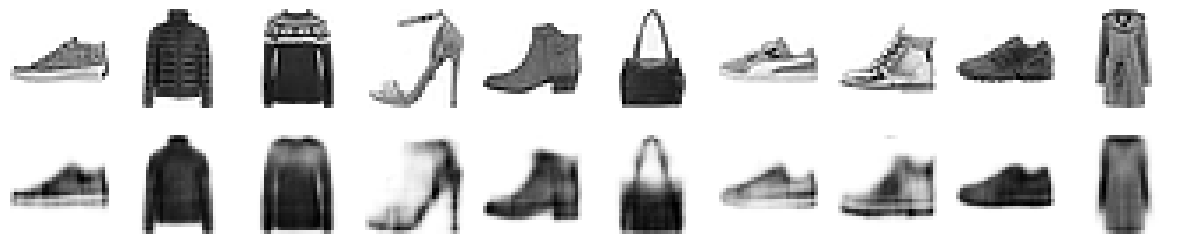

In [16]:
plot_reconstruction(stacked, x_val, 10)
plt.show()

##### Anomaly Detection With Autoencoders

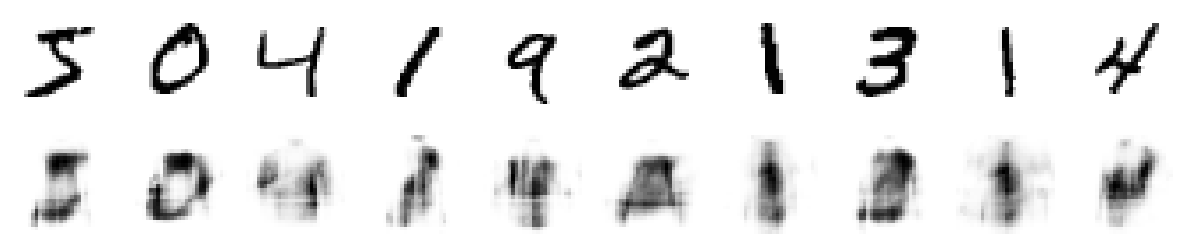

In [17]:
torch.manual_seed(42)
mnist_data = torchvision.datasets.MNIST(root='datasets', train=True, download=True, transform=toTensor)
mnist_image = torch.stack([mnist_data[i][0] for i in range(x_val.size(0))])
plot_reconstruction(stacked, mnist_image, 10)
plt.show()

In [18]:
images = mnist_image.to(device)
with torch.no_grad():
    y_pred = stacked(images)
    recon_loss = torch.nn.functional.mse_loss(y_pred, images)
recon_loss

tensor(0.0389, device='cuda:0')

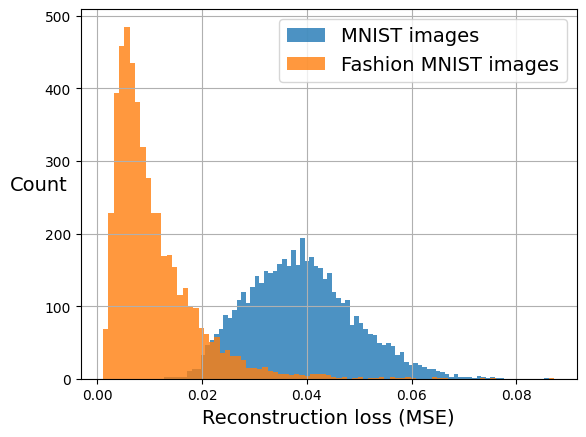

In [19]:
import torch.nn.functional as F
def compute_reconstruction_losses(X, device):
    X = X.to(device)
    with torch.no_grad():
        y_pred = stacked(X)
        return F.mse_loss(y_pred, X, reduction="none").view(X.size(0), -1).mean(dim=1).cpu()

recon_losses_mnist = compute_reconstruction_losses(mnist_image, device)
recon_losses_fashion_mnist = compute_reconstruction_losses(x_val, device)

plt.hist(recon_losses_mnist, bins=85, alpha=0.8, label="MNIST images")
plt.hist(recon_losses_fashion_mnist, bins=85, alpha=0.8, label="Fashion MNIST images")
plt.xlabel("Reconstruction loss (MSE)")
plt.ylabel("Count", rotation=0)
plt.legend()
plt.grid()

plt.show()

##### Using Autoencoder for dim reduction

In [20]:
from sklearn.manifold import TSNE

with torch.no_grad():
    x_val_compressed = stacked_encoder(x_val.to(device))
tsne = TSNE(init='pca', random_state=42)
x_val_2d = tsne.fit_transform(x_val_compressed.cpu())

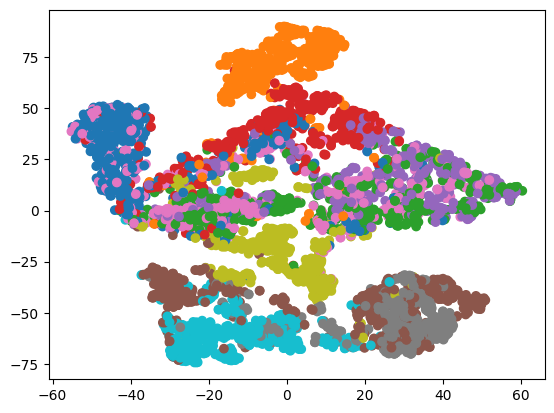

In [21]:
y_val = torch.tensor([y for _, y in valid_data])
plt.scatter(x_val_2d[:, 0], x_val_2d[:, 1], c=y_val, cmap='tab10')
plt.show()

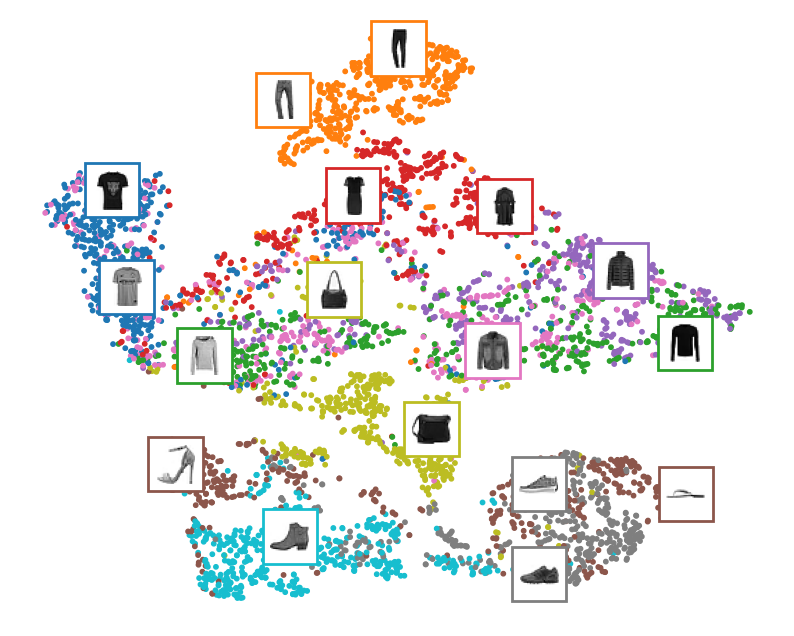

In [22]:
import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = x_val_2d
Z = (Z - Z.min()) / (Z.max() - Z.min())
plt.scatter(Z[:, 0], Z[:, 1], c=y_val, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02:
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_val[index].squeeze(dim=0),
                                      cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_val[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")

plt.show()


##### Tying  (tie the weights of the decoder layers to the weights of the encoder layer)

In [23]:
class TiedAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder1 = nn.Linear(1 * 28 * 28, 128)
        self.encoder2 = nn.Linear(128, 32)
        self.decoder_bias = nn.Parameter(torch.zeros(128))
        self.decoder_bias2 = nn.Parameter(torch.zeros(1 * 28 * 28))

    def encode(self, X):
        Z = X.view(-1, 1 * 28 * 28)
        Z = F.relu(self.encoder1(Z))
        return F.relu(self.encoder2(Z))

    def decode(self, X):
        Z = F.relu(F.linear(X, self.encoder2.weight.t(), self.decoder_bias))
        Z = F.sigmoid(F.linear(Z, self.encoder1.weight.t(), self.decoder_bias2))
        return Z.view(-1, 1, 28, 28)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.decode(self.encode(x))

In [24]:
tied_model = TiedAutoencoder().to(device)
optimizer = torch.optim.NAdam(tied_model.parameters(), lr= 0.01)
history = training_func(tied_model, optimizer, loss_fn, rmse, train_loader, val_loader, 20)

Epoch 1 / 20: Train Loss:  0.0229, Train Metric = 0.1514, Valid Metric = 0.1382, Scheduler Best[0.1382]
Epoch 2 / 20: Train Loss:  0.0174, Train Metric = 0.1319, Valid Metric = 0.1340, Scheduler Best[0.1382]
Epoch 3 / 20: Train Loss:  0.0166, Train Metric = 0.1290, Valid Metric = 0.1320, Scheduler Best[0.1382]
Epoch 4 / 20: Train Loss:  0.0162, Train Metric = 0.1274, Valid Metric = 0.1261, Scheduler Best[0.1382]
Epoch 5 / 20: Train Loss:  0.0142, Train Metric = 0.1191, Valid Metric = 0.1204, Scheduler Best[0.1382]
Epoch 6 / 20: Train Loss:  0.0139, Train Metric = 0.1177, Valid Metric = 0.1180, Scheduler Best[0.1382]
Epoch 7 / 20: Train Loss:  0.0136, Train Metric = 0.1168, Valid Metric = 0.1179, Scheduler Best[0.1382]
Epoch 8 / 20: Train Loss:  0.0128, Train Metric = 0.1131, Valid Metric = 0.1141, Scheduler Best[0.1382]
Epoch 9 / 20: Train Loss:  0.0127, Train Metric = 0.1125, Valid Metric = 0.1135, Scheduler Best[0.1382]
Epoch 10 / 20: Train Loss:  0.0125, Train Metric = 0.1119, Valid

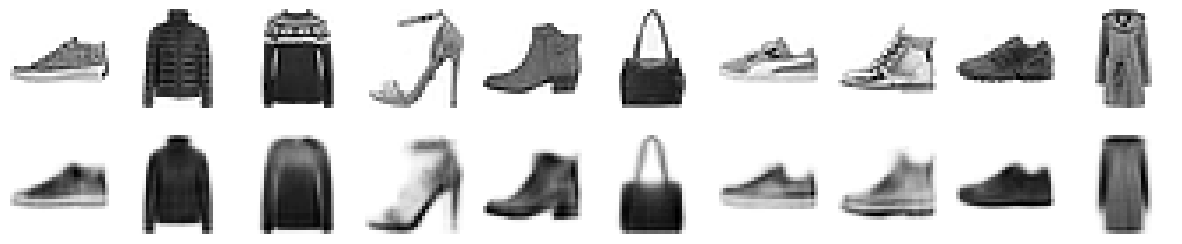

In [25]:
plot_reconstruction(tied_model, x_val, 10)

##### Convolutional Autoencoder

In [37]:
convo_encoder = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(16, 32, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(32, 64, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(64, 128, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(128, 32, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
)

convo_decoder = nn.Sequential(
    nn.Linear(32, 16 * 3 * 3),
    nn.Unflatten(dim = 1, unflattened_size=(16, 3, 3) ),
    nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding= 1, output_padding=1),
    nn.ReLU(),
    nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding= 1, output_padding=1),
    nn.Sigmoid(),
)

convo_ae = nn.Sequential(convo_encoder, convo_decoder).to(device)

In [38]:
optimizer = torch.optim.NAdam(convo_ae.parameters(), lr=0.005)
history = training_func(convo_ae, optimizer, mse, rmse, train_loader, val_loader,
                n_epochs=10)

Epoch 1 / 10: Train Loss:  0.0317, Train Metric = 0.1780, Valid Metric = 0.1470, Scheduler Best[0.1470]
Epoch 2 / 10: Train Loss:  0.0197, Train Metric = 0.1403, Valid Metric = 0.1351, Scheduler Best[0.1470]
Epoch 3 / 10: Train Loss:  0.0175, Train Metric = 0.1322, Valid Metric = 0.1297, Scheduler Best[0.1470]
Epoch 4 / 10: Train Loss:  0.0164, Train Metric = 0.1280, Valid Metric = 0.1257, Scheduler Best[0.1470]
Epoch 5 / 10: Train Loss:  0.0148, Train Metric = 0.1217, Valid Metric = 0.1219, Scheduler Best[0.1470]
Epoch 6 / 10: Train Loss:  0.0146, Train Metric = 0.1207, Valid Metric = 0.1206, Scheduler Best[0.1470]
Epoch 7 / 10: Train Loss:  0.0143, Train Metric = 0.1196, Valid Metric = 0.1203, Scheduler Best[0.1470]
Epoch 8 / 10: Train Loss:  0.0138, Train Metric = 0.1174, Valid Metric = 0.1184, Scheduler Best[0.1470]
Epoch 9 / 10: Train Loss:  0.0137, Train Metric = 0.1170, Valid Metric = 0.1181, Scheduler Best[0.1470]
Epoch 10 / 10: Train Loss:  0.0136, Train Metric = 0.1166, Valid

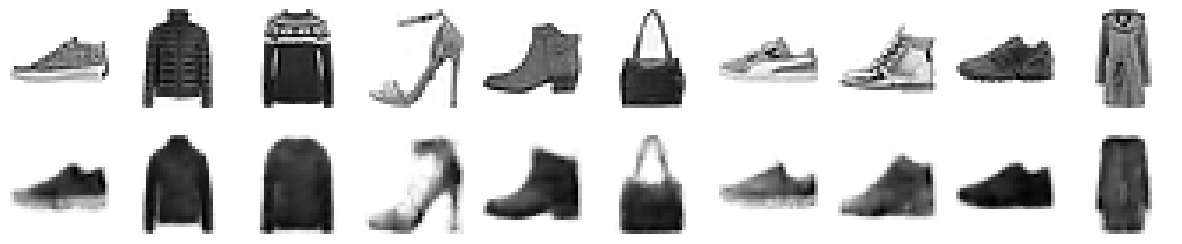

In [39]:
plot_reconstruction(convo_ae, x_val, 10)
plt.show()

##### Understanding RNN autoencoder

In [49]:
class RNNAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder_lstm = nn.LSTM(input_size=28, hidden_size=128, num_layers=2, batch_first=True)
        self.encoder_proj = nn.Linear(128, 32)
        self.decoder_lstm = nn.LSTM(input_size=32, hidden_size=128, num_layers=2, batch_first=True)
        self.decode_proj = nn.Linear(128, 28)

    def encode(self, x):
        x = x.squeeze(dim=1)
        _, (h_n, _) = self.encoder_lstm(x)
        x = h_n[-1]
        return self.encoder_proj(x)

    def decode(self, x):
        x = x.unsqueeze(dim = 1).repeat(1, 28, 1)
        x, _ = self.decoder_lstm(x)
        return F.sigmoid(self.decode_proj(x).unsqueeze(dim=1))

    def forward(self, x):
        return self.decode(self.encode(x))


In [52]:
rnnautoencoder = RNNAutoencoder().to(device)
optimizer = torch.optim.NAdam(rnnautoencoder.parameters(), lr = 1e-3)
history = training_func(rnnautoencoder, optimizer, mse, rmse, train_loader, val_loader,
                n_epochs=10)

Epoch 1 / 10: Train Loss:  0.0874, Train Metric = 0.2957, Valid Metric = 0.2364, Scheduler Best[0.2364]
Epoch 2 / 10: Train Loss:  0.0458, Train Metric = 0.2140, Valid Metric = 0.1983, Scheduler Best[0.2364]
Epoch 3 / 10: Train Loss:  0.0322, Train Metric = 0.1793, Valid Metric = 0.1667, Scheduler Best[0.2364]
Epoch 4 / 10: Train Loss:  0.0244, Train Metric = 0.1563, Valid Metric = 0.1490, Scheduler Best[0.2364]
Epoch 5 / 10: Train Loss:  0.0206, Train Metric = 0.1437, Valid Metric = 0.1419, Scheduler Best[0.2364]
Epoch 6 / 10: Train Loss:  0.0192, Train Metric = 0.1385, Valid Metric = 0.1378, Scheduler Best[0.2364]
Epoch 7 / 10: Train Loss:  0.0179, Train Metric = 0.1340, Valid Metric = 0.1327, Scheduler Best[0.2364]
Epoch 8 / 10: Train Loss:  0.0169, Train Metric = 0.1299, Valid Metric = 0.1298, Scheduler Best[0.2364]
Epoch 9 / 10: Train Loss:  0.0164, Train Metric = 0.1279, Valid Metric = 0.1281, Scheduler Best[0.2364]
Epoch 10 / 10: Train Loss:  0.0159, Train Metric = 0.1260, Valid

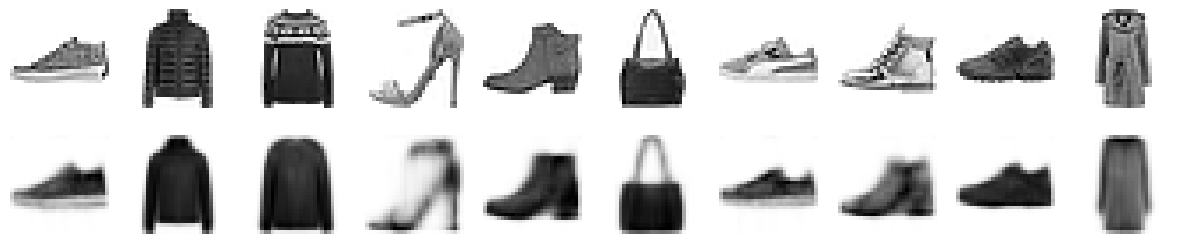

In [53]:
plot_reconstruction(rnnautoencoder, x_val, 10)
plt.show()

##### MHA AutoEncoder

In [54]:
#Simple MHA
class MHABlock(nn.Module):
    def __init__(self, input_dim, num_heads =2):
        super().__init__()
        self.mha = nn.MultiheadAttention(input_dim, num_heads, batch_first=True)
        self.norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        attn, _ = self.mha(x, x, x)
        return self.norm(attn + x)

In [90]:
import torch.nn.functional as F

class AutoEncoderMHA(nn.Module):
    def __init__(self):
        super().__init__()

        self.convo_encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding='same'), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding='same'), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding='same'), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding='same'), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 32, 3, padding='same'), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(32,32)
        )

        self.to_token = nn.Linear(32, 4*8)
        self.mha = MHABlock(input_dim=8, num_heads=2)
        self.from_token = nn.Linear(4*8, 32)

        self.first_expand = nn.ConvTranspose2d(32, 64, kernel_size=4, stride=1, padding=0)

        self.convo_decoder = nn.Sequential(
            nn.Linear(32, 64 * 3 * 3),
            nn.Unflatten(dim=1, unflattened_size=(64, 3, 3)),

            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )


    def forward(self, x):
        z = self.convo_encoder(x)
        tokens = self.to_token(z).view(-1, 4, 8)
        tokens = self.mha(tokens)
        z2 = self.from_token(tokens.view(-1, 32))
        return self.convo_decoder(z2)




In [91]:
aemha = AutoEncoderMHA().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(aemha.parameters(), lr=1e-3)
training_func(aemha, optimizer, criterion, rmse, train_loader, val_loader, 10)

Epoch 1 / 10: Train Loss:  0.0290, Train Metric = 0.1702, Valid Metric = 0.1459, Scheduler Best[0.1459]
Epoch 2 / 10: Train Loss:  0.0192, Train Metric = 0.1387, Valid Metric = 0.1376, Scheduler Best[0.1459]
Epoch 3 / 10: Train Loss:  0.0177, Train Metric = 0.1332, Valid Metric = 0.1335, Scheduler Best[0.1459]
Epoch 4 / 10: Train Loss:  0.0169, Train Metric = 0.1298, Valid Metric = 0.1295, Scheduler Best[0.1459]
Epoch 5 / 10: Train Loss:  0.0156, Train Metric = 0.1248, Valid Metric = 0.1249, Scheduler Best[0.1459]
Epoch 6 / 10: Train Loss:  0.0152, Train Metric = 0.1233, Valid Metric = 0.1233, Scheduler Best[0.1459]
Epoch 7 / 10: Train Loss:  0.0148, Train Metric = 0.1216, Valid Metric = 0.1236, Scheduler Best[0.1459]
Epoch 8 / 10: Train Loss:  0.0142, Train Metric = 0.1193, Valid Metric = 0.1201, Scheduler Best[0.1459]
Epoch 9 / 10: Train Loss:  0.0141, Train Metric = 0.1185, Valid Metric = 0.1192, Scheduler Best[0.1459]
Epoch 10 / 10: Train Loss:  0.0139, Train Metric = 0.1179, Valid

{'train_loss': [0.02897114483525824,
  0.019248048903842074,
  0.01773019829995761,
  0.01685208320691358,
  0.01558145577518173,
  0.01519522370923356,
  0.014774655833853373,
  0.014224262483886087,
  0.014051711292414037,
  0.01389233813062527],
 'train_metrics': [0.1702115386724472,
  0.1387384682893753,
  0.13315477967262268,
  0.12981517612934113,
  0.1248244196176529,
  0.12327176332473755,
  0.12155073881149292,
  0.11926668882369995,
  0.11853818595409393,
  0.11786582320928574],
 'val_metric': [0.1459183245897293,
  0.13759374618530273,
  0.13346126675605774,
  0.12947238981723785,
  0.12489765882492065,
  0.12332602590322495,
  0.12358029931783676,
  0.1200682744383812,
  0.11918258666992188,
  0.11857854574918747]}

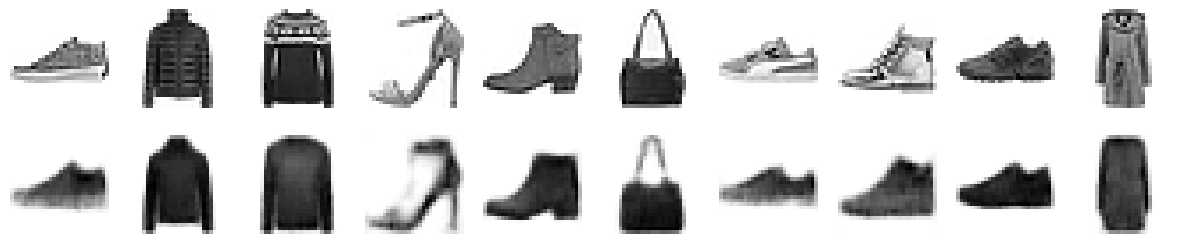

In [93]:
plot_reconstruction(aemha, x_val, 10)

#### Denoising Autoencoder

In [97]:
class GaussianNoise(nn.Module):
    def __init__(self, std):
        super().__init__()
        self.std = std
    def forward(self, x):
        if self.training:
            noise = torch.rand_like(x) * self.std
            return x + noise
        return x

In [101]:
torch.manual_seed(42)
noise_encoder = nn.Sequential(
    nn.Flatten(),
    GaussianNoise(0.5),
    nn.Linear(1 * 28 * 28, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
)

noise_decoder = nn.Sequential(
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 1 * 28 * 28),
    nn.Sigmoid(),
    nn.Unflatten(dim = 1, unflattened_size=(1, 28, 28) )
)

noise_ae = nn.Sequential(noise_encoder, noise_decoder).to(device)

In [102]:
optimizer = torch.optim.NAdam(noise_ae.parameters(), lr= 0.01)
training_func(noise_ae, optimizer, mse, rmse, train_loader, val_loader, 10)

Epoch 1 / 10: Train Loss:  0.0306, Train Metric = 0.1750, Valid Metric = 0.1750, Scheduler Best[0.1750]
Epoch 2 / 10: Train Loss:  0.0219, Train Metric = 0.1480, Valid Metric = 0.1545, Scheduler Best[0.1750]
Epoch 3 / 10: Train Loss:  0.0206, Train Metric = 0.1436, Valid Metric = 0.1449, Scheduler Best[0.1750]
Epoch 4 / 10: Train Loss:  0.0200, Train Metric = 0.1414, Valid Metric = 0.1465, Scheduler Best[0.1750]
Epoch 5 / 10: Train Loss:  0.0176, Train Metric = 0.1325, Valid Metric = 0.1470, Scheduler Best[0.1750]
Epoch 6 / 10: Train Loss:  0.0171, Train Metric = 0.1309, Valid Metric = 0.1607, Scheduler Best[0.1750]
Epoch 7 / 10: Train Loss:  0.0168, Train Metric = 0.1296, Valid Metric = 0.1722, Scheduler Best[0.1750]
Epoch 8 / 10: Train Loss:  0.0159, Train Metric = 0.1260, Valid Metric = 0.1801, Scheduler Best[0.1801]
Epoch 9 / 10: Train Loss:  0.0157, Train Metric = 0.1253, Valid Metric = 0.1967, Scheduler Best[0.1967]
Epoch 10 / 10: Train Loss:  0.0156, Train Metric = 0.1248, Valid

{'train_loss': [0.030619523121198988,
  0.021899663038668832,
  0.02063450057204724,
  0.019994174374604448,
  0.017568953540620415,
  0.01713413897568036,
  0.016804001219310583,
  0.015878638778144084,
  0.015694109005111295,
  0.015579048267318074],
 'train_metrics': [0.17498867213726044,
  0.14798834919929504,
  0.14364466071128845,
  0.1414000689983368,
  0.13254721462726593,
  0.13089756667613983,
  0.1296306848526001,
  0.12600991129875183,
  0.1252773106098175,
  0.12481587380170822],
 'val_metric': [0.17500868439674377,
  0.15449441969394684,
  0.14488311111927032,
  0.1465112268924713,
  0.146995410323143,
  0.16070556640625,
  0.17218661308288574,
  0.18007758259773254,
  0.19670610129833221,
  0.20004485547542572]}

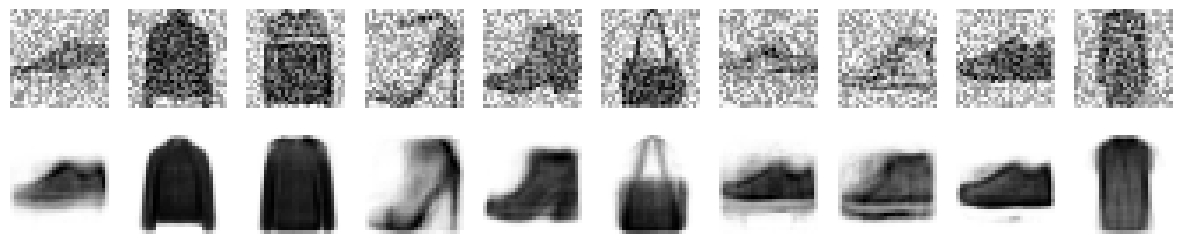

In [106]:
noise = GaussianNoise(0.8)
plot_reconstruction(noise_ae, noise(x_val), 10)

##### Sparse Autoencoder

In [8]:
from collections import namedtuple

ae_output = namedtuple('AEOutput', ['output', 'codings'])

class SparseAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.Sigmoid(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1 * 28 * 28),
            nn.Sigmoid(),
            nn.Unflatten(dim = 1, unflattened_size=(1, 28, 28))
        )
    def forward(self, x):
        coding = self.encoder(x)
        output = self.decoder(coding)
        return ae_output(output, coding)
sp_model = SparseAutoencoder().to(device)

In [9]:
def mse_plus_sparsity_loss(y_pred, y_target, target_sparsity=0.1,
                           kl_weight=1e-3, eps=1e-8):
    p = torch.tensor(target_sparsity, device=y_pred.codings.device)
    q = torch.clamp(y_pred.codings.mean(dim=0), eps, 1 - eps)  # actual sparsity
    kl_div = p * torch.log(p / q) + (1 - p) * torch.log((1 - p) / (1 - q))
    return mse(y_pred.output, y_target) + kl_weight * kl_div.sum()

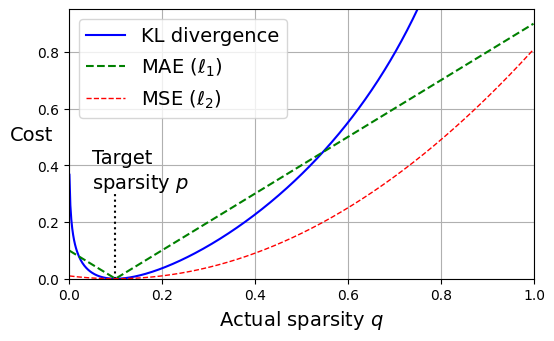

In [10]:
plt.figure(figsize=(6, 3.5))
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse_ = (p - q) ** 2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity $p$", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse_, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity $q$")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
plt.grid(True)

In [115]:
optimizer = torch.optim.NAdam(sp_model.parameters(), lr=0.002)
history = training_func(sp_model, optimizer, mse_plus_sparsity_loss, rmse,
                train_loader, val_loader, n_epochs=10)

Epoch 1 / 10: Train Loss:  0.0325, Train Metric = 0.1761, Valid Metric = 0.1441, Scheduler Best[0.1441]
Epoch 2 / 10: Train Loss:  0.0189, Train Metric = 0.1348, Valid Metric = 0.1310, Scheduler Best[0.1441]
Epoch 3 / 10: Train Loss:  0.0157, Train Metric = 0.1231, Valid Metric = 0.1193, Scheduler Best[0.1441]
Epoch 4 / 10: Train Loss:  0.0138, Train Metric = 0.1153, Valid Metric = 0.1134, Scheduler Best[0.1441]
Epoch 5 / 10: Train Loss:  0.0120, Train Metric = 0.1079, Valid Metric = 0.1072, Scheduler Best[0.1441]
Epoch 6 / 10: Train Loss:  0.0114, Train Metric = 0.1053, Valid Metric = 0.1050, Scheduler Best[0.1441]
Epoch 7 / 10: Train Loss:  0.0109, Train Metric = 0.1030, Valid Metric = 0.1033, Scheduler Best[0.1441]
Epoch 8 / 10: Train Loss:  0.0104, Train Metric = 0.1003, Valid Metric = 0.1009, Scheduler Best[0.1441]
Epoch 9 / 10: Train Loss:  0.0101, Train Metric = 0.0993, Valid Metric = 0.0998, Scheduler Best[0.1441]
Epoch 10 / 10: Train Loss:  0.0099, Train Metric = 0.0983, Valid

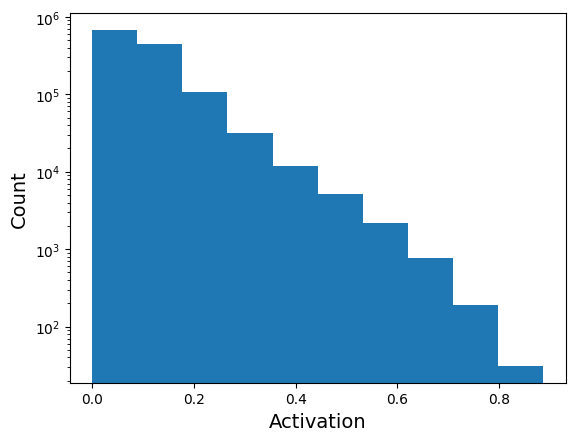

In [120]:
with torch.no_grad():
    y_pred = sp_model(x_val.to(device))

encs = y_pred.codings.flatten().detach().cpu()
plt.hist(encs, log=True)
plt.xlabel("Activation")
plt.ylabel("Count")
plt.show()

In [103]:
import math
def plot_multiple_images(images, n_cols=None, title=None):
    if isinstance(images, torch.Tensor):
        if images.dim() == 4:
            images = [images[i] for i in range(images.shape[0])]
        elif images.dim() == 3:
            images = [images]
        else:
            raise ValueError(f"Unsupported tensor shape, got {images.shape}")
    n_images = len(images)
    n_cols = n_cols or min(4, n_images)  # default to 4 columns
    n_rows = math.ceil(n_images / n_cols)

    plt.figure(figsize=(n_cols * 3, n_rows * 3))
    if title:
        plt.suptitle(title, fontsize=16)

    for idx, img_tensor in enumerate(images):
        plt.subplot(n_rows, n_cols, idx + 1)

        # Convert from tensor to numpy + correct format
        if isinstance(img_tensor, torch.Tensor):
            img = img_tensor.cpu()
            if img.shape[0] in (1, 3):  # (C, H, W)
                img = img.permute(1, 2, 0)  # to (H, W, C)
            img = img.clamp(0, 1).numpy() if img.max() <= 1.0 else (img / 255.0).numpy()

        plt.imshow(img)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


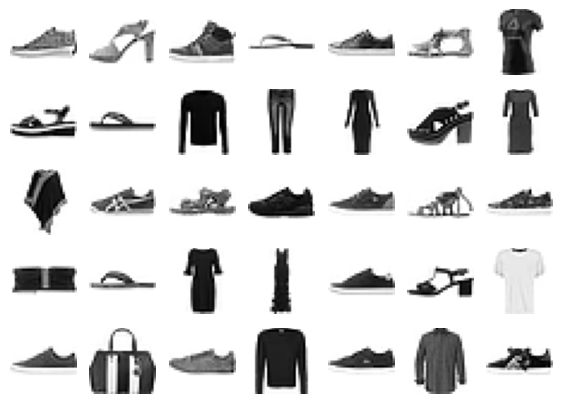

In [121]:
dim = 6
codings = y_pred.codings[:, dim].cpu()
threshold = np.percentile(codings, 90)
selected_images = x_val[codings > threshold]
plot_multiple_images(selected_images[:35], 7)
plt.show()

##### Variational Autoencoder

In [51]:
VAEOutput = namedtuple('VAEOutput', ['output', 'mean', 'logvar'])

class VAE(nn.Module):
    def __init__(self, coding_dim = 32):
        super(VAE, self).__init__()
        self.coding_dim = coding_dim
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 2 * coding_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(coding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1 * 28 * 28),
            nn.Sigmoid(),
            nn.Unflatten(dim = 1, unflattened_size=(1, 28, 28)
                         ),
        )
    def encode(self, x):
        return self.encoder(x).chunk(2, dim=-1)

    def sample_coding(self, coding_mean, coding_logvar):
        coding_std = torch.exp(0.5 * coding_logvar)
        noise = torch.randn_like(coding_std)
        return coding_mean + noise * coding_std
    def decode(self,x):
        return self.decoder(x)
    def forward(self, x):
        coding_mean, coding_logvar = self.encode(x)
        codings = self.sample_coding(coding_mean, coding_logvar)
        output = self.decode(codings)
        return VAEOutput(output, coding_mean, coding_logvar)

In [32]:
def vae_loss (y_pred, y_target, kl_weight = 1.0):
    output, mean , logvar = y_pred
    kl_div = -0.5 * torch.sum(1 + logvar - logvar.exp() - mean.square(), dim=-1)
    return F.mse_loss(output, y_target) + kl_weight * kl_div.mean() / 784

In [44]:
torch.manual_seed(1)
vae_model = VAE().to(device)
optimizer = torch.optim.NAdam(vae_model.parameters(), lr = 1e-3)
training_func(vae_model, optimizer, vae_loss, rmse, train_loader, val_loader, 20)

Epoch 1 / 20: Train Loss:  0.0486, Train Metric = 0.1983, Valid Metric = 0.1728, Scheduler Best[0.1728]
Epoch 2 / 20: Train Loss:  0.0370, Train Metric = 0.1656, Valid Metric = 0.1620, Scheduler Best[0.1728]
Epoch 3 / 20: Train Loss:  0.0348, Train Metric = 0.1583, Valid Metric = 0.1578, Scheduler Best[0.1728]
Epoch 4 / 20: Train Loss:  0.0339, Train Metric = 0.1549, Valid Metric = 0.1553, Scheduler Best[0.1728]
Epoch 5 / 20: Train Loss:  0.0331, Train Metric = 0.1523, Valid Metric = 0.1519, Scheduler Best[0.1728]
Epoch 6 / 20: Train Loss:  0.0329, Train Metric = 0.1514, Valid Metric = 0.1522, Scheduler Best[0.1728]
Epoch 7 / 20: Train Loss:  0.0328, Train Metric = 0.1507, Valid Metric = 0.1515, Scheduler Best[0.1728]
Epoch 8 / 20: Train Loss:  0.0325, Train Metric = 0.1497, Valid Metric = 0.1508, Scheduler Best[0.1728]
Epoch 9 / 20: Train Loss:  0.0324, Train Metric = 0.1493, Valid Metric = 0.1507, Scheduler Best[0.1728]
Epoch 10 / 20: Train Loss:  0.0323, Train Metric = 0.1490, Valid

{'train_loss': [0.04862042938409467,
  0.03697764340174829,
  0.03476689717666814,
  0.033880448376260364,
  0.03314396373845242,
  0.0329131784590439,
  0.03275163194848362,
  0.0324752829175761,
  0.03241600805742925,
  0.032315472670770645,
  0.032185048011194976,
  0.03214225096605315,
  0.03211731510914086,
  0.03203632278392799,
  0.03201888438255687,
  0.03201136432930506,
  0.0319953762718659,
  0.03196105242226275,
  0.03195141604004418,
  0.03191643189628018],
 'train_metrics': [0.19829776883125305,
  0.16556589305400848,
  0.15834365785121918,
  0.15490181744098663,
  0.15229856967926025,
  0.151412695646286,
  0.1507105529308319,
  0.14970263838768005,
  0.14934343099594116,
  0.14902998507022858,
  0.14854010939598083,
  0.1483772099018097,
  0.1482916921377182,
  0.14799802005290985,
  0.1479453593492508,
  0.14785638451576233,
  0.1477692872285843,
  0.1476932317018509,
  0.14764277637004852,
  0.1475898176431656],
 'val_metric': [0.17283296585083008,
  0.162009298801422

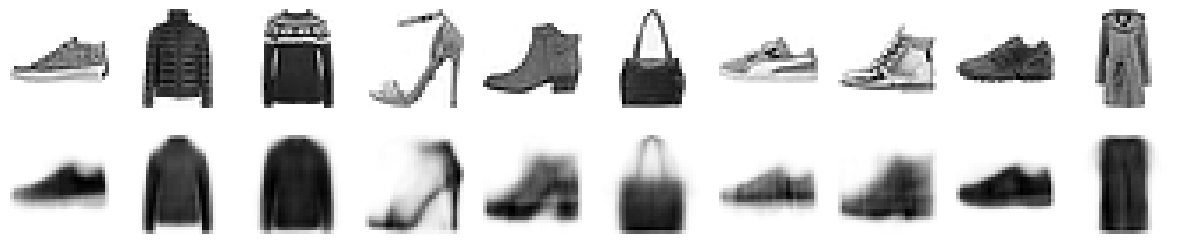

In [45]:
plot_reconstruction(vae_model, x_val, 10)
plt.show()

In [52]:
torch.manual_seed(42)
vae_model.eval()
coding= torch.randn(4 * 7, vae_model.coding_dim).to(device)
with torch.no_grad():
    images = vae_model.decode(coding)

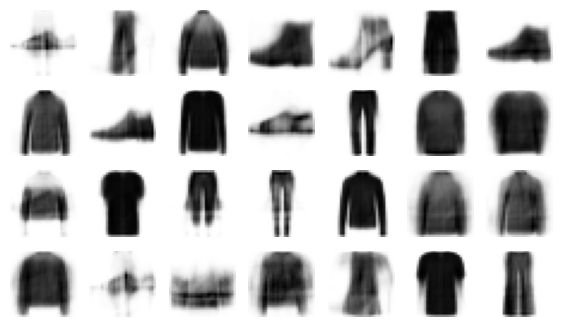

In [53]:
plot_multiple_images(images , 7)
plt.show()

In [54]:
torch.manual_seed(111)

codings = torch.randn(2, vae_model.coding_dim)
n_images = 7
weights = torch.linspace(0, 1, n_images).view(n_images, 1)
codings = torch.lerp(codings[0], codings[1], weights)
with torch.no_grad():
    images = vae_model.decode(codings.to(device))

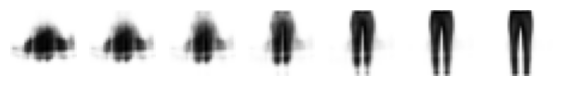

In [55]:
plot_multiple_images(images)

##### DVA

In [56]:
def gumbel_softmax(logits, tau = 1, hard = 'False', dim = -1):
    return F.gumbel_softmax(logits, tau=tau, hard=hard, dim=dim)

In [93]:
DiscreteVAEOutput = namedtuple('DiscreteVAEOutput', ['output', 'logits', 'coding_prob'])

class DiscreteVAE(nn.Module):
    def __init__(self, coding_length = 128, n_codes = 64, temperature = 1.0):
        super().__init__()
        self.coding_length = coding_length
        self.n_codes = n_codes
        self.temperature = temperature
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding='same'), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding='same'), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding='same'), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding='same'), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 32, 3, padding='same'), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
        )

        self.to_logits = nn.Linear(32, coding_length * n_codes)
        self.from_codes = nn.Linear(coding_length * n_codes, 32 * 4 *4)
        self.decoder = nn.Sequential(
            nn.Unflatten(dim=1, unflattened_size=(32, 4, 4)),
            nn.Conv2d(32, 128, 3, padding='same'), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=1, padding=0), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1), nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        logits = self.to_logits(encoded)
        logits = logits.clamp(-10, 10)
        logits = logits.view(-1, self.coding_length, self.n_codes)
        coding_prob = F.gumbel_softmax(logits, tau=self.temperature, dim=-1)
        flat_codes = coding_prob.view(-1, self.coding_length * self.n_codes)
        decoded_input = self.from_codes(flat_codes)
        output = self.decoder(decoded_input)
        output = output[:, :, :28, :28]
        return DiscreteVAEOutput(output, logits, coding_prob)

In [94]:
def d_vae_loss(y_pred, y_target, kl_weight=1.0):
    output, logits, _ = y_pred
    codings_prob = F.softmax(logits, -1)
    k = logits.new_tensor(logits.size(-1))
    kl_div = (codings_prob * (codings_prob.log() + k.log())).sum(dim=(1, 2))
    return F.mse_loss(output, y_target) + kl_weight * kl_div.mean() / 784

In [95]:
n_epochs = 20
def annealing(model, epoch):
    t = 1-0.9 * epoch / n_epochs
    model.temperature = max(t, 0.5)

torch.manual_seed(42)
d_vae = DiscreteVAE().to(device)
optimizer = torch.optim.NAdam(d_vae.parameters(), lr=0.0003)
history = training_func(d_vae, optimizer, d_vae_loss, rmse, train_loader, val_loader,
                n_epochs=n_epochs, epoch_callback=annealing)

Epoch 1 / 20: Train Loss:  0.0638, Train Metric = 0.2464, Valid Metric = 0.2057, Scheduler Best[0.2057]
Epoch 2 / 20: Train Loss:  0.0431, Train Metric = 0.1935, Valid Metric = 0.1904, Scheduler Best[0.2057]
Epoch 3 / 20: Train Loss:  0.0409, Train Metric = 0.1863, Valid Metric = 0.1866, Scheduler Best[0.2057]
Epoch 4 / 20: Train Loss:  0.0403, Train Metric = 0.1842, Valid Metric = 0.1832, Scheduler Best[0.2057]
Epoch 5 / 20: Train Loss:  0.0397, Train Metric = 0.1817, Valid Metric = 0.1809, Scheduler Best[0.2057]
Epoch 6 / 20: Train Loss:  0.0394, Train Metric = 0.1801, Valid Metric = 0.1793, Scheduler Best[0.2057]
Epoch 7 / 20: Train Loss:  0.0393, Train Metric = 0.1793, Valid Metric = 0.1791, Scheduler Best[0.2057]
Epoch 8 / 20: Train Loss:  0.0392, Train Metric = 0.1786, Valid Metric = 0.1791, Scheduler Best[0.2057]
Epoch 9 / 20: Train Loss:  0.0394, Train Metric = 0.1786, Valid Metric = 0.1806, Scheduler Best[0.2057]
Epoch 10 / 20: Train Loss:  0.0397, Train Metric = 0.1791, Valid

In [132]:
batch = 16
codings = torch.randint(0, d_vae.n_codes, (batch, d_vae.coding_length)).to(device)
with torch.no_grad():
    one_hot_codes = F.one_hot(codings, num_classes=d_vae.n_codes).float()
    flat_code = one_hot_codes.view(batch, -1)
    z = d_vae.from_codes(flat_code)
    images = d_vae.decoder(z)

In [133]:
images.shape

torch.Size([16, 1, 60, 60])

.##### GAB

In [146]:
torch.manual_seed(42)
coding_dim = 32
generator = nn.Sequential(
    nn.Linear(coding_dim, 128), nn.ReLU(),
    nn.Linear(128, 1 * 28 * 28), nn.Sigmoid(),
    nn.Unflatten(dim = 1, unflattened_size=(1, 28, 28))
).to(device)
discriminator = nn.Sequential(
    nn.Flatten(), nn.Linear(1 * 28 * 28, 256), nn.ReLU(),
    nn.Linear(256, 128), nn.ReLU(),
    nn.Linear(128, 1), nn.Sigmoid()
).to(device)

In [147]:
def train_gan(generator, discriminator, train_loader, coding_dim, n_epochs = 20, g_lr = 1e-3, d_lr = 5e-4):
    loss_fn = nn.BCELoss()
    generator_opt = torch.optim.NAdam(generator.parameters(), lr=g_lr)
    discriminator_opt = torch.optim.NAdam(discriminator.parameters(), lr=d_lr)
    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}/{n_epochs}')
        for real_images, _ in train_loader:
            real_images = real_images.to(device)
            pred_real = discriminator(real_images)
            batch_size = real_images.size(0)
            ones = torch.ones(batch_size, 1, device=device)
            real_loss = loss_fn(pred_real, ones)
            coding = torch.randn(batch_size, coding_dim, device=device)
            fake_images = generator(coding).detach()
            pred_fake = discriminator(fake_images)
            zeros = torch.zeros(batch_size, 1, device=device)
            fake_loss = loss_fn(pred_fake, zeros)
            discriminator_loss = real_loss + fake_loss
            discriminator_opt.zero_grad()
            discriminator_loss.backward()
            discriminator_opt.step()

            coding = torch.randn(batch_size, coding_dim, device=device)
            fake_images = generator(coding)
            for p in discriminator.parameters():
                p.requires_grad = False
            pred_fake = discriminator(fake_images)
            generator_loss = loss_fn(pred_fake, ones)
            generator_opt.zero_grad()
            generator_loss.backward()
            generator_opt.step()
            for p in discriminator.parameters():
                p.requires_grad = True
        print(f'Discriminator loss: {discriminator_loss.item():.6f}, Generator loss: {generator_loss.item():.6f}')
        if epoch % 10 == 0 or  epoch == n_epochs - 1:
            plot_multiple_images(fake_images.detach(), 8)
            plt.show()


Epoch 1/20
Discriminator loss: 0.265245, Generator loss: 3.128311


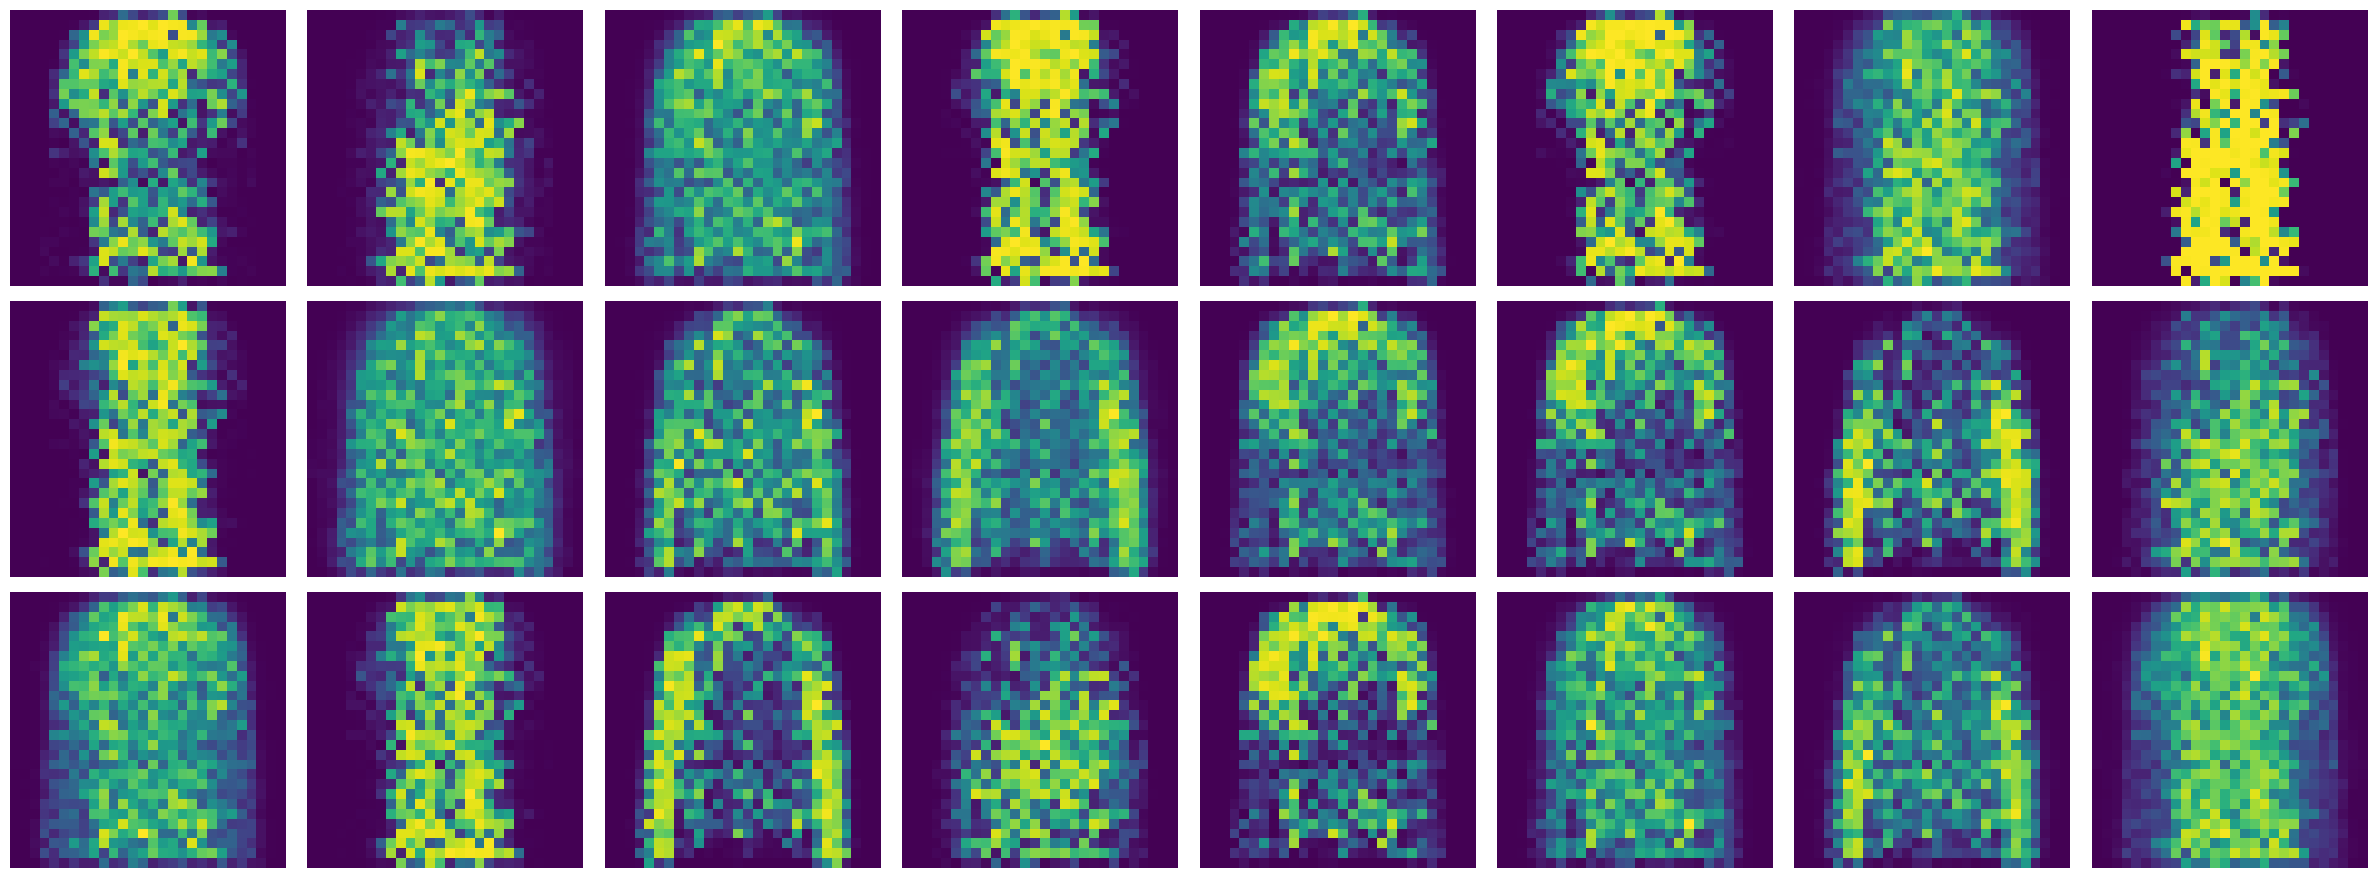

Epoch 2/20
Discriminator loss: 1.378612, Generator loss: 0.839107
Epoch 3/20
Discriminator loss: 0.634908, Generator loss: 2.252434
Epoch 4/20
Discriminator loss: 1.282613, Generator loss: 0.642778
Epoch 5/20
Discriminator loss: 0.598023, Generator loss: 2.246100
Epoch 6/20
Discriminator loss: 0.594975, Generator loss: 2.125004
Epoch 7/20
Discriminator loss: 0.397000, Generator loss: 3.525817
Epoch 8/20
Discriminator loss: 0.698281, Generator loss: 1.604564
Epoch 9/20
Discriminator loss: 0.626391, Generator loss: 1.965604
Epoch 10/20
Discriminator loss: 0.665118, Generator loss: 2.748053
Epoch 11/20
Discriminator loss: 0.978511, Generator loss: 1.199110


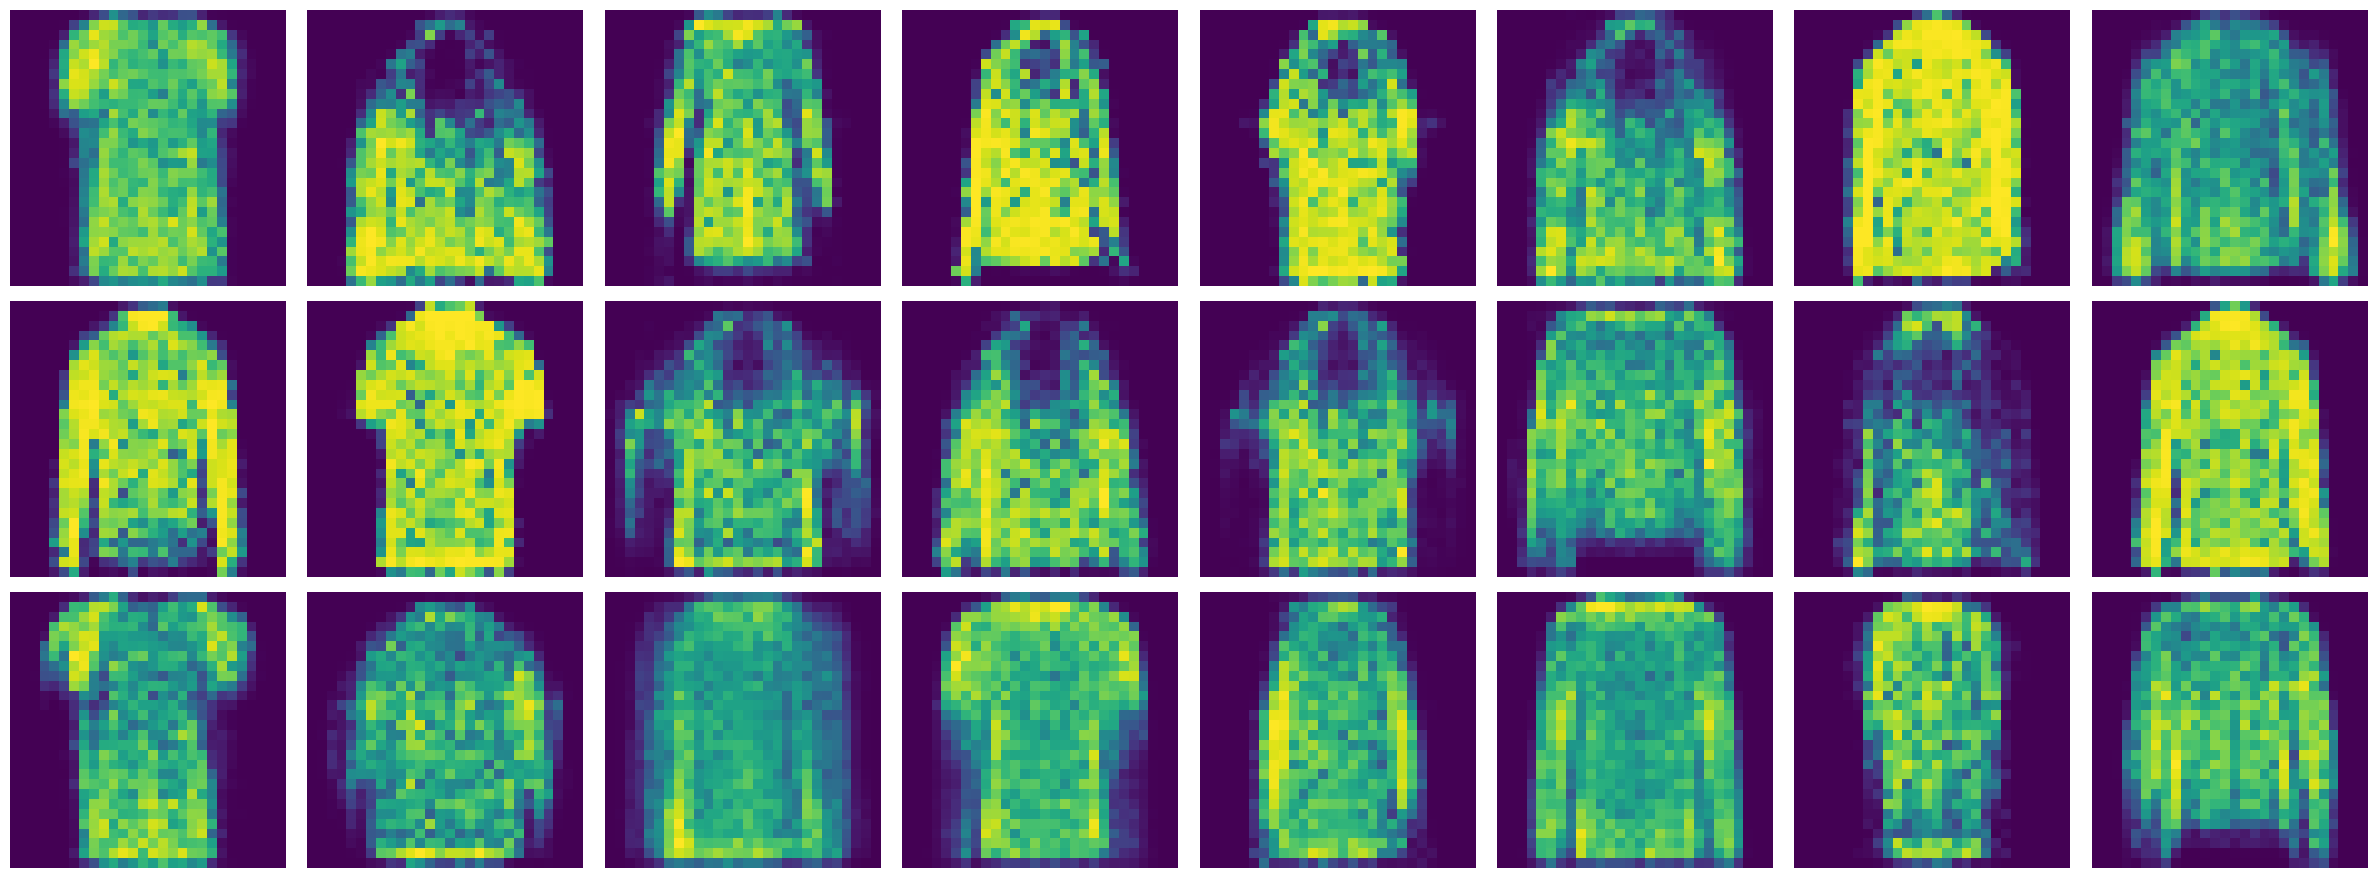

Epoch 12/20
Discriminator loss: 0.857627, Generator loss: 1.571980
Epoch 13/20
Discriminator loss: 0.721846, Generator loss: 1.981889
Epoch 14/20
Discriminator loss: 0.781455, Generator loss: 1.826859
Epoch 15/20
Discriminator loss: 0.662005, Generator loss: 1.889355
Epoch 16/20
Discriminator loss: 0.793527, Generator loss: 1.711690
Epoch 17/20
Discriminator loss: 0.731664, Generator loss: 1.672558
Epoch 18/20
Discriminator loss: 0.617807, Generator loss: 1.928187
Epoch 19/20
Discriminator loss: 0.550165, Generator loss: 1.764464
Epoch 20/20
Discriminator loss: 0.746281, Generator loss: 1.808328


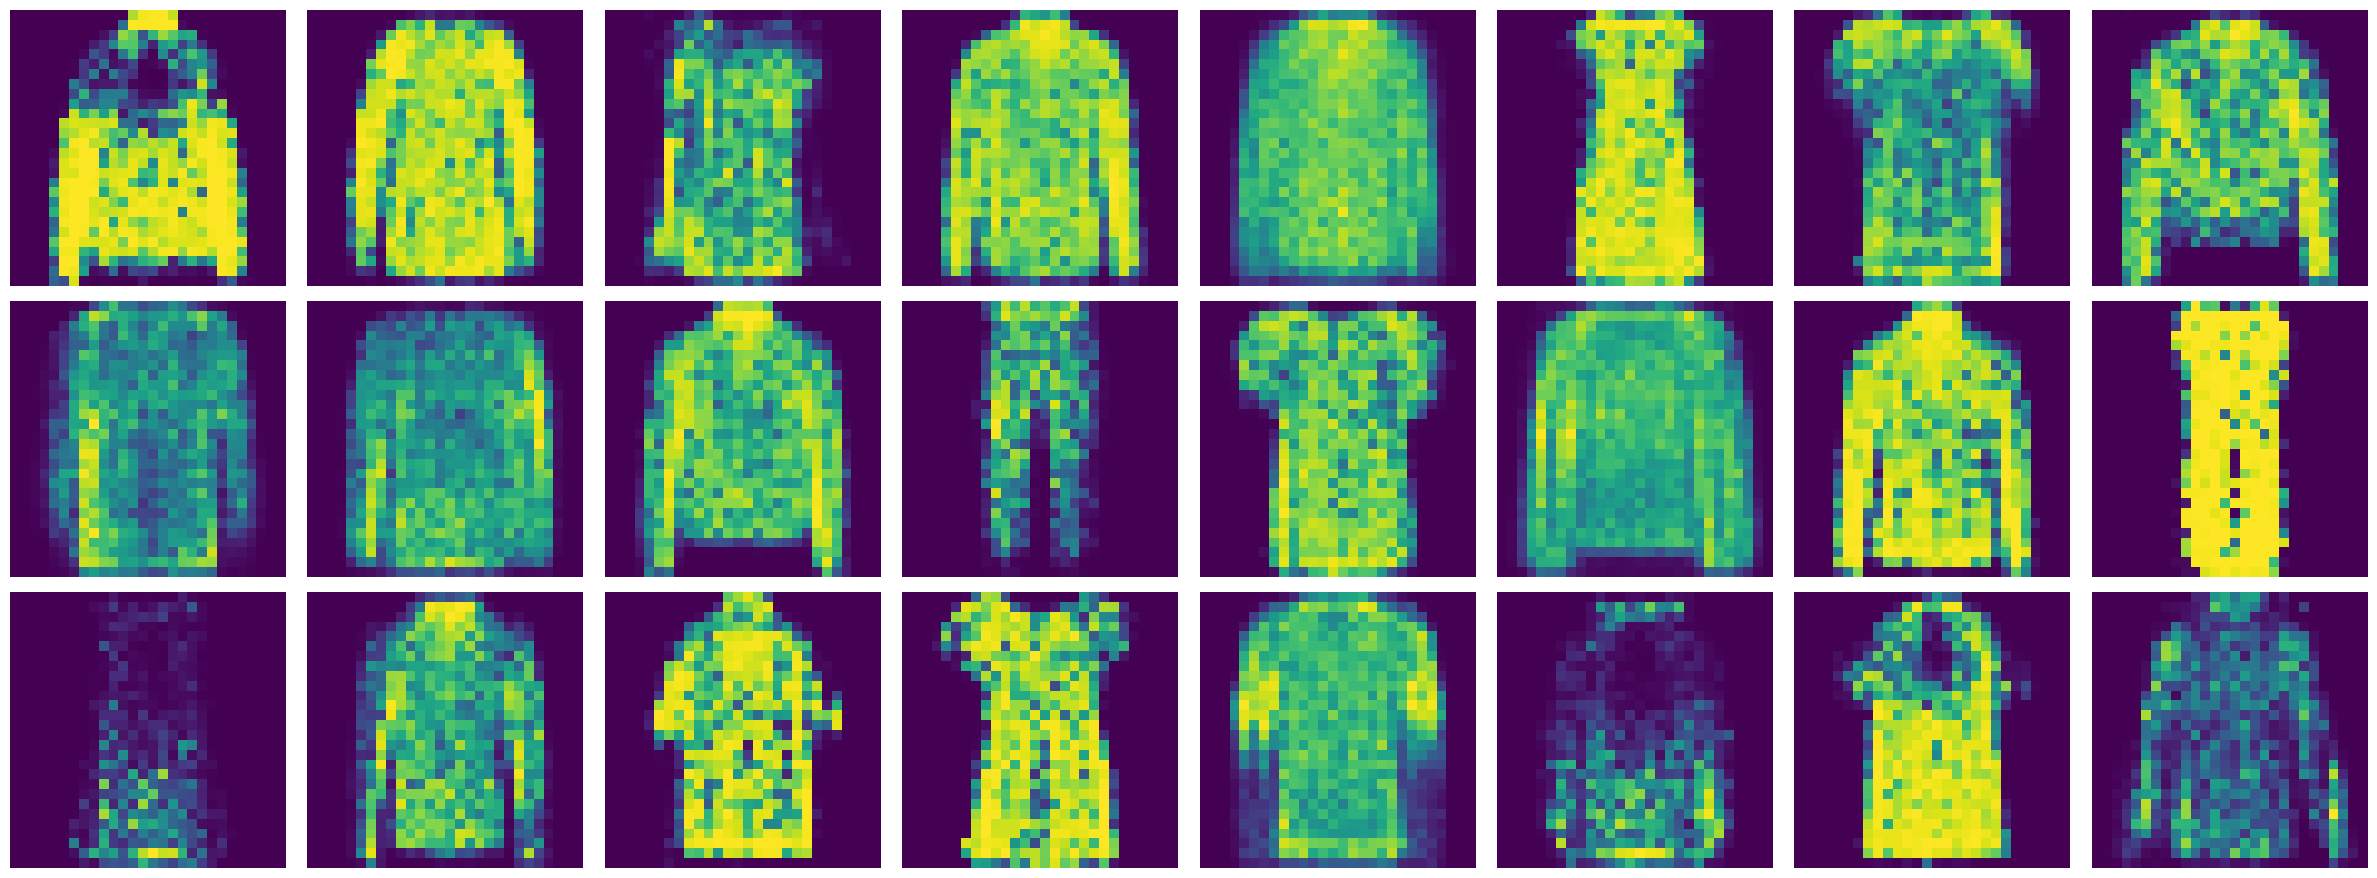

In [148]:
torch.manual_seed(-42)
train_gan(generator, discriminator, train_loader, coding_dim, n_epochs)

In [150]:
torch.manual_seed(42)
n_images = 3  * 7
generator.eval()
coding = torch.randn(n_images, coding_dim).to(device)
with torch.no_grad():
    generated_images = generator(coding)

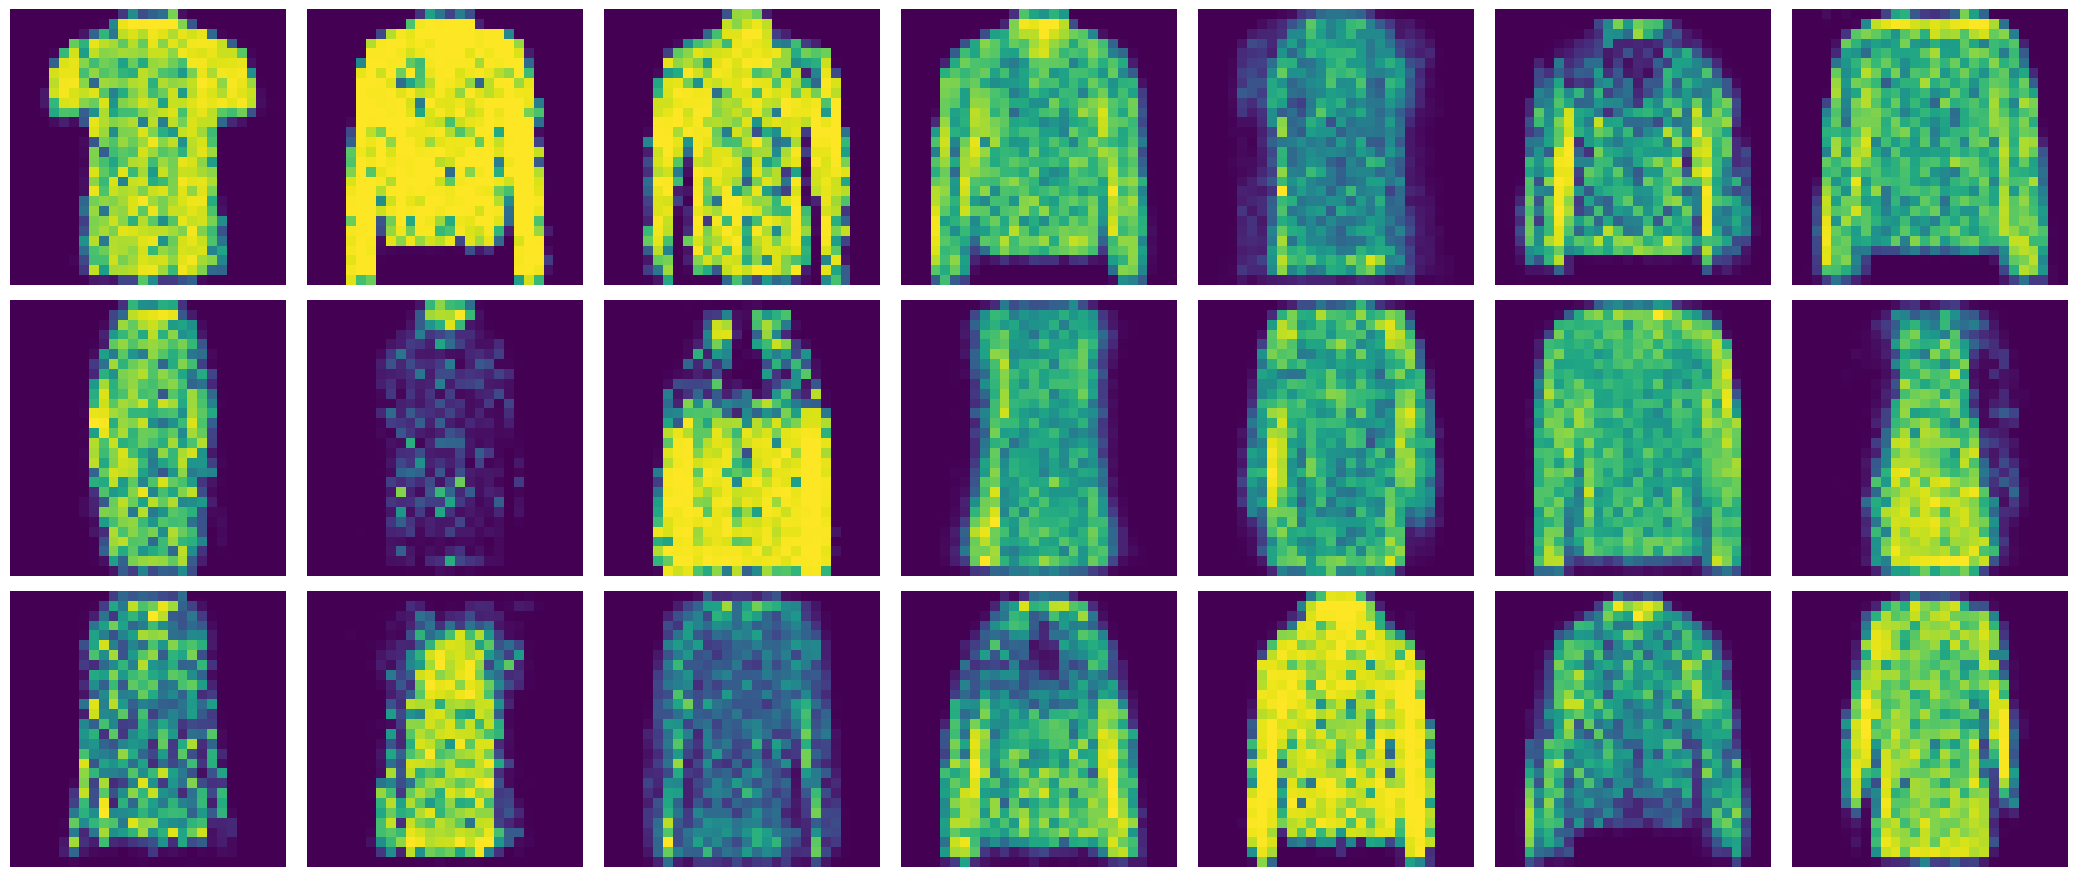

In [151]:
plot_multiple_images(generated_images, 7)
plt.show()